In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 128
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.utils.image_dataset_from_directory(
    './fruitdataset',
    labels="inferred",
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
    seed=123,
)

Found 500 files belonging to 5 classes.


In [4]:
class_names = dataset.class_names
class_names

['Alphonso', 'Amrapali', 'Ataulfo', 'Irwin', 'Keitt']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(labels_batch.numpy())

[1 3 4 0 4 2 3 0 2 3 4 0 4 4 3 2 3 2 1 2 0 1 4 4 1 3 1 2 3 1 2 0]


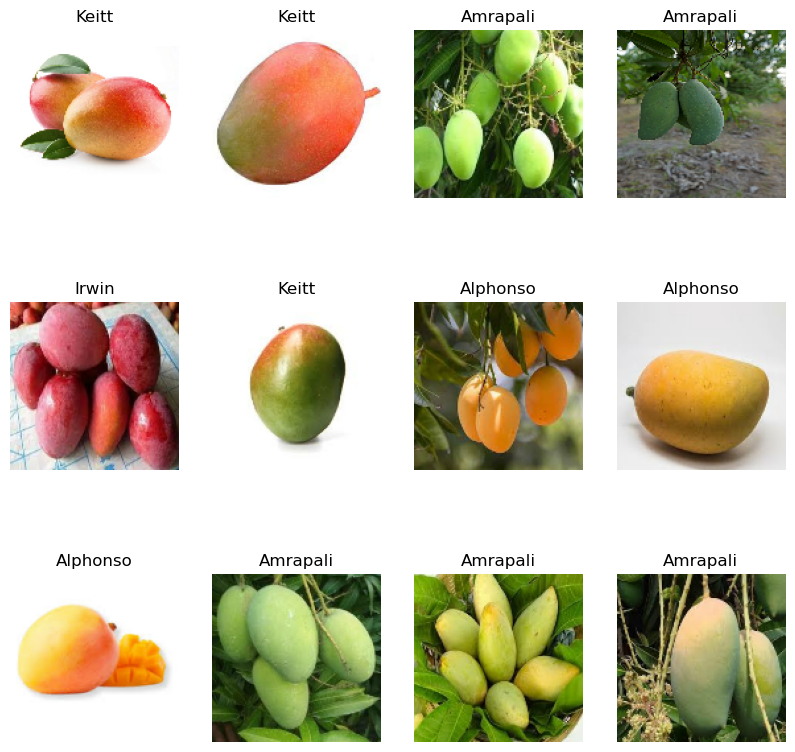

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [8]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [9]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [11]:
len(train_ds)

12

In [12]:
len(val_ds)

1

In [13]:
len(test_ds)

3

In [14]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

In [15]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(16, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 128, 128, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (32, 126, 126, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (32, 63, 63, 16)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 61, 61, 32)          4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 30, 30, 32)          0         
 g2D)                                                 

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    verbose = 1,
    epochs = EPOCHS,
)

Epoch 1/50
12/12 [==============================] - 5s 254ms/step - loss: 1.5961 - accuracy: 0.2849 - val_loss: 1.5550 - val_accuracy: 0.3125
Epoch 2/50
12/12 [==============================] - 3s 231ms/step - loss: 1.4507 - accuracy: 0.4194 - val_loss: 1.1886 - val_accuracy: 0.4375
Epoch 3/50
12/12 [==============================] - 3s 244ms/step - loss: 1.0998 - accuracy: 0.5054 - val_loss: 0.9658 - val_accuracy: 0.4688
Epoch 4/50
12/12 [==============================] - 4s 271ms/step - loss: 0.9616 - accuracy: 0.6022 - val_loss: 0.7987 - val_accuracy: 0.6562
Epoch 5/50
12/12 [==============================] - 3s 236ms/step - loss: 0.7994 - accuracy: 0.6478 - val_loss: 0.6559 - val_accuracy: 0.6562
Epoch 6/50
12/12 [==============================] - 3s 226ms/step - loss: 0.7025 - accuracy: 0.6720 - val_loss: 0.6636 - val_accuracy: 0.7188
Epoch 7/50
12/12 [==============================] - 3s 230ms/step - loss: 0.6712 - accuracy: 0.6953 - val_loss: 0.7127 - val_accuracy: 0.6875
Epoch 

In [27]:
test_result = model.evaluate(test_ds)

3/3 [==============================] - 1s 39ms/step - loss: 0.3132 - accuracy: 0.8750


In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

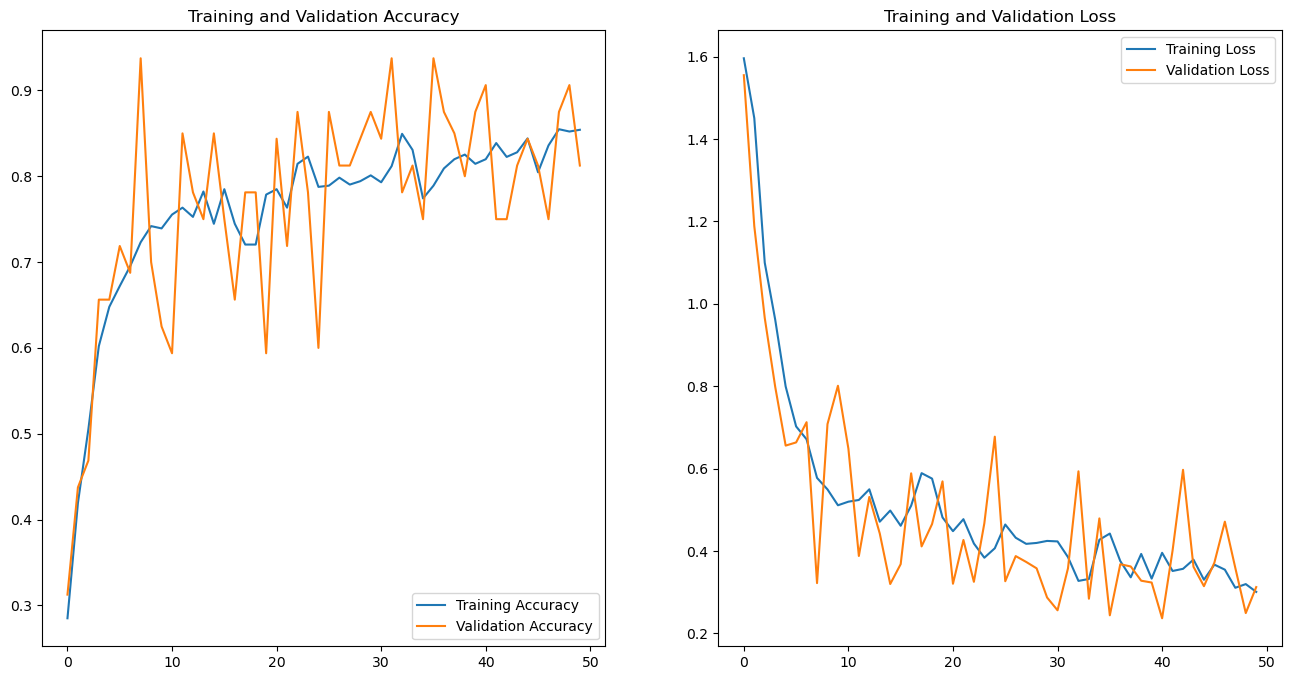

In [30]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [31]:
import numpy as np



def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


1/1 [==============================] - 0s 13ms/step


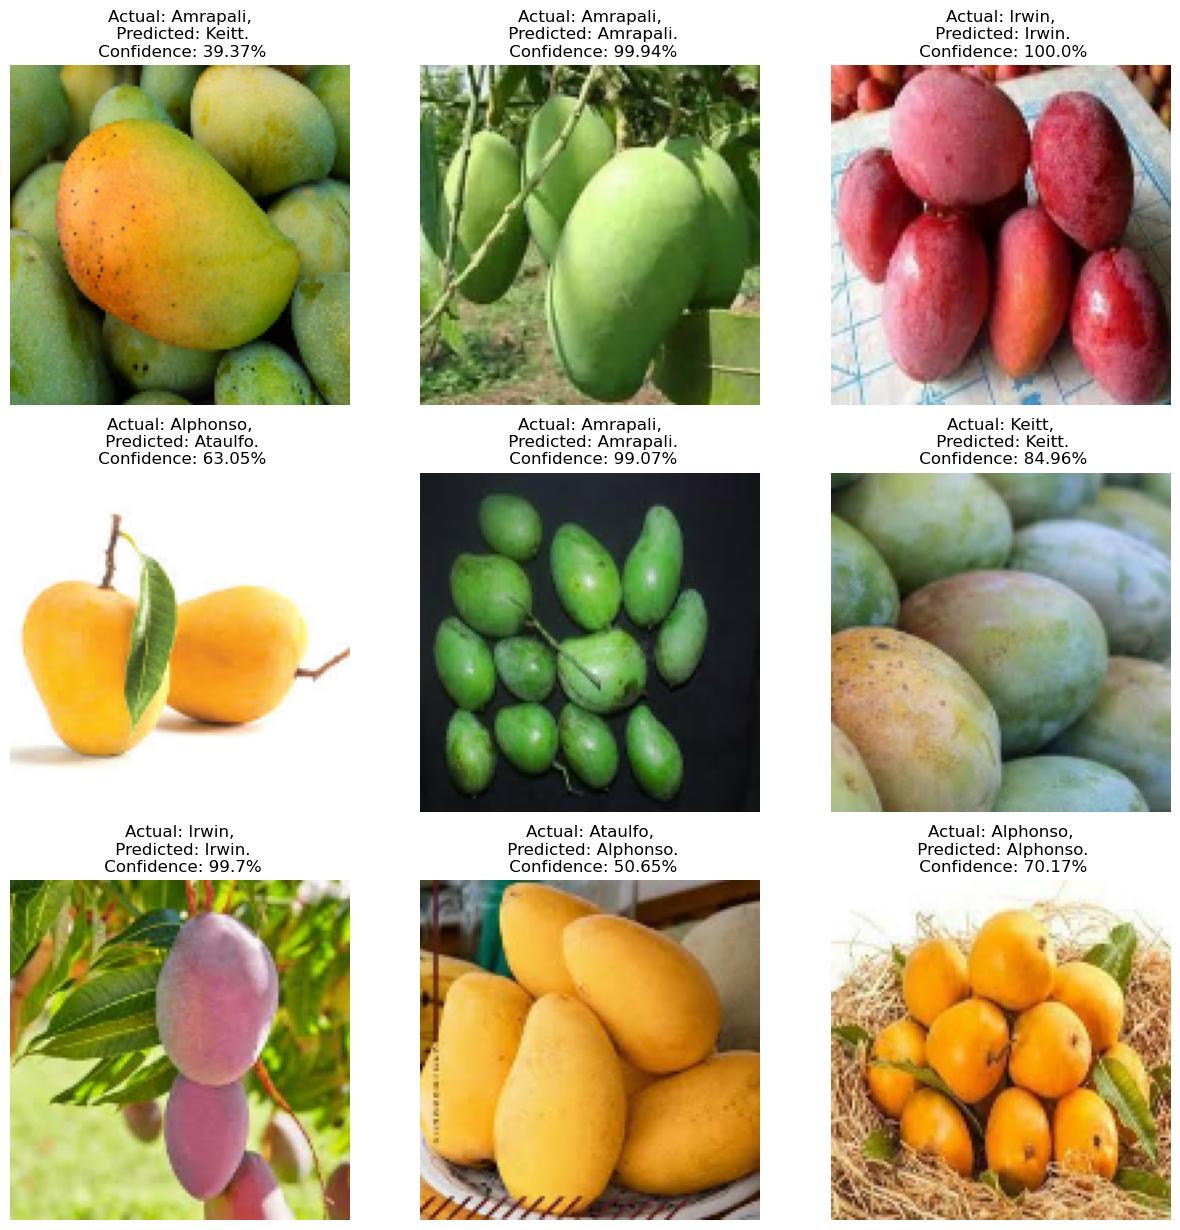

In [32]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [33]:
y_true = []
y_predicted = []


for images_batch, labels_batch in test_ds.take(1):
    batch_prediction = model.predict(images_batch)
    for i in range(0, len(images_batch)):
        
        predict = np.argmax(batch_prediction[i])
        true = labels_batch[i].numpy()
        
        y_true.append(true)
        y_predicted.append(predict)
        


1/1 [==============================] - 0s 47ms/step


In [34]:
y_true[1], y_predicted[1]

(1, 1)

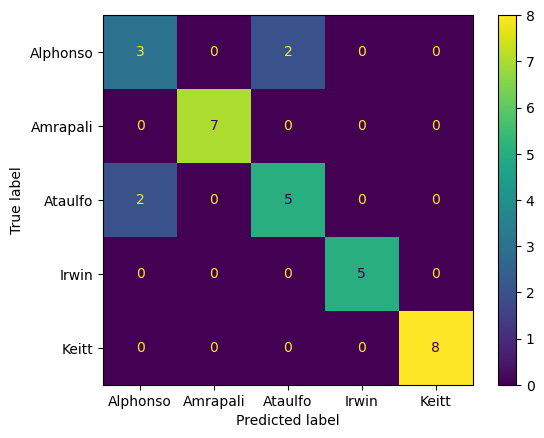

In [35]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_true, y_predicted)

display_labels = []

for i in range(0, 5):
    display_labels.append(class_names[i])
    

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = display_labels)

cm_display.plot()
plt.show() 

In [36]:
model.save("saved_models\\my_model_1")

INFO:tensorflow:Assets written to: saved_models\my_model_1\assets


INFO:tensorflow:Assets written to: saved_models\my_model_1\assets


In [4]:
my_model = models.load_model("saved_models/my_model_1")

In [5]:
my_model.layers

In [6]:
for layer in my_model.layers:
    if "conv" in layer.name:
        filters, biases = layer.get_weights()
        print(layer.name, filters.shape)

conv2d (3, 3, 3, 16)
conv2d_1 (3, 3, 16, 32)
conv2d_2 (3, 3, 32, 32)
conv2d_3 (3, 3, 32, 32)
conv2d_4 (3, 3, 32, 32)


In [ ]:
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# Filters of CNN

<function matplotlib.pyplot.show(close=None, block=None)>

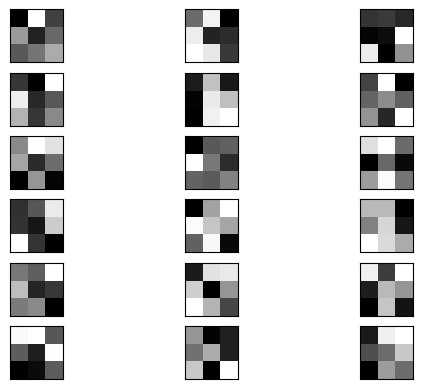

In [8]:
number_of_filters = 6
idx = 1

for i in range(number_of_filters):
    f = filters[:, :, :, i]
    for j in range(3):
        ax = plt.subplot(number_of_filters, 3, idx)
        ax.set_xticks([])
        ax.set_yticks([])
        
        plt.imshow(f[:, :, j], cmap = "gray")
        idx += 1
        
plt.show

In [17]:
from tensorflow.keras.models import Model
from PIL import Image
import numpy as np


model_1 = Model(inputs = my_model.inputs, outputs = my_model.layers[2].output)
img = Image.open("./fruitdataset/Alphonso/Image_16.jpeg") 

In [18]:
img = img.resize((128, 128))
img = tf.convert_to_tensor(img)
img_array = tf.keras.preprocessing.image.img_to_array(img.numpy())
img_array = tf.expand_dims(img_array, 0)

img_array.shape

TensorShape([1, 128, 128, 3])

In [19]:
feature_maps_1 = model_1.predict(img_array)

1/1 [==============================] - 0s 216ms/step


# Output Images of Layer 2

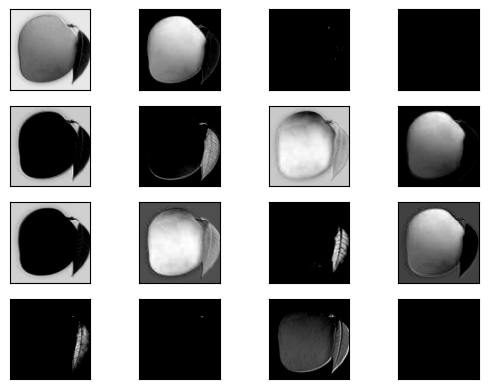

In [21]:
square = 4
idx = 1
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, idx)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(feature_maps_1[0, :, :, idx - 1], cmap = "gray")
        idx += 1

plt.show()

# Output Images of Layer 4

1/1 [==============================] - 0s 98ms/step


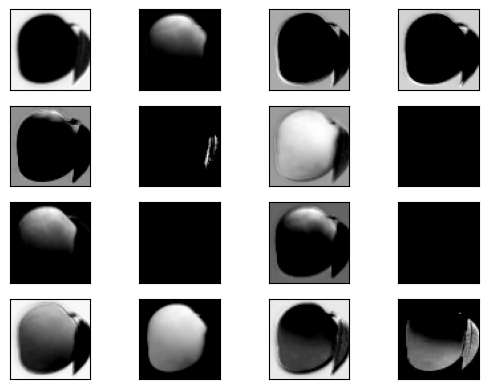

In [23]:
model_2 = Model(inputs = my_model.inputs, outputs = my_model.layers[4].output)
feature_maps_2 = model_2.predict(img_array)

square = 4
idx = 1
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, idx)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(feature_maps_2[0, :, :, idx - 1], cmap = "gray")
        idx += 1

plt.show()

# Output Images of Layer 6

1/1 [==============================] - 0s 103ms/step


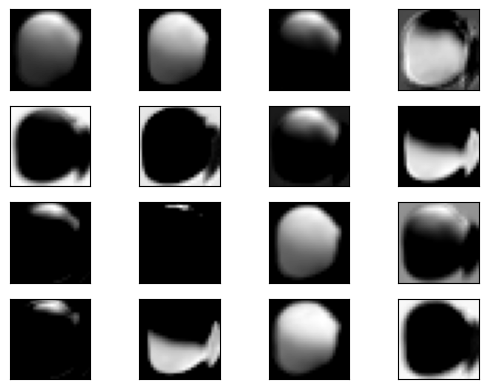

In [26]:
model_3 = Model(inputs = my_model.inputs, outputs = my_model.layers[6].output)
feature_maps_3 = model_3.predict(img_array)

square = 4
idx = 1
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, idx)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(feature_maps_3[0, :, :, idx - 1], cmap = "gray")
        idx += 1

plt.show()

# Output Images of Layer 8

1/1 [==============================] - 0s 115ms/step


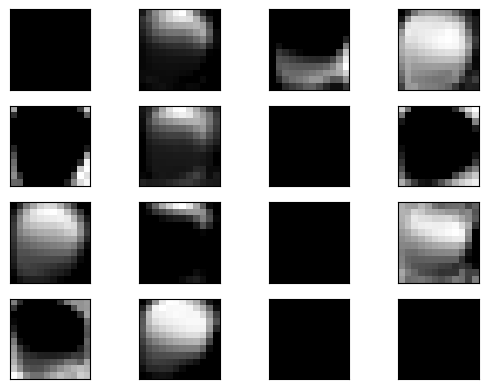

In [27]:
model_4 = Model(inputs = my_model.inputs, outputs = my_model.layers[8].output)
feature_maps_4 = model_4.predict(img_array)

square = 4
idx = 1
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, idx)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(feature_maps_4[0, :, :, idx - 1], cmap = "gray")
        idx += 1

plt.show()

# Output Images of Layer 10

1/1 [==============================] - 0s 118ms/step


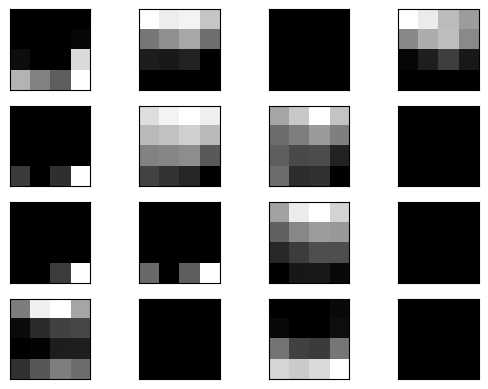

In [30]:
model_5 = Model(inputs = my_model.inputs, outputs = my_model.layers[10].output)
feature_maps_5 = model_5.predict(img_array)

square = 4
idx = 1
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, idx)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(feature_maps_5[0, :, :, idx - 1], cmap = "gray")
        idx += 1

plt.show()